In [104]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver  
import pandas as pd
import time
# To ignore warnings
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import silhouette_score


from sklearn import metrics

%matplotlib inline

# web scraiping


In [3]:
url = 'https://foursquare.com/explore?mode=url&ne=25.66137%2C46.765409&q=Food&sw=24.601685%2C46.668591'
page = requests.get(url)
print(page.status_code)

200


In [4]:
soup = BeautifulSoup(page.content, 'html.parser')
print(type(soup))

<class 'bs4.BeautifulSoup'>


In [5]:
page_title = soup.title.text # gets you the text of the <title>(...)</title>
page_title

'Food Saudi Arabia'

In [9]:
driver = webdriver.Chrome()
# request the page 
driver.get(url)

        # extract the body and parse it
soup = BeautifulSoup(driver.page_source, "html.parser")
driver.quit()

In [7]:

driver = webdriver.Chrome()
url = 'https://foursquare.com/explore?mode=url&ne=25.66137%2C46.765409&q=Food&sw=25.601685%2C46.668591'
columns_ = ['Name', 'Score', 'Category', 'Price_Range']
df = pd.DataFrame(columns=columns_)

for i in range(2, 12):  # Adjust the range to try 10 pages
    # Request the page
    driver.get(url)
    time.sleep(2)
    # Extract the body and parse it
    soup = BeautifulSoup(driver.page_source, "html.parser")

    # Extract names, scores, categories, and price ranges from the page
    names = soup.find_all('div', {'class': 'venueName'})
    scores = soup.find_all('div', {'class': 'venueScore positive', 'title': '', 'style': 'background-color: #00B551;'})
    categories = soup.find_all('span', {'class': 'categoryName'})
    price_ranges = soup.find_all('span', {'class': 'venueDataItem'})

    # Clean the data
    clean_Name = [p.text.strip() for p in names]
    clean_Score = [n.text.strip() for n in scores]
    clean_Category = [m.text.strip() for m in categories]

    # Extract and clean price ranges
    clean_Price_Range = []
    for span in price_ranges:
        price_span = span.find('span', {'class': 'price'})
        if price_span:
            price_text = price_span.find('span', {'class': 'darken'})
            if price_text:
                clean_Price_Range.append(price_text.text.strip())
        """            else:
                clean_Price_Range.append('Unknown')
        else:
            clean_Price_Range.append('Unknown')
        """
    # Check if all lists have the same length before creating the DataFrame
    min_length = min(len(clean_Name), len(clean_Score), len(clean_Category), len(clean_Price_Range))
    clean_Name = clean_Name[:min_length]
    clean_Score = clean_Score[:min_length]
    clean_Category = clean_Category[:min_length]
    clean_Price_Range = clean_Price_Range[:min_length]
    
    # Store the data in a DataFrame
    new_rows_df = pd.DataFrame({
        'Name': clean_Name,
        'Score': clean_Score,
        'Category': clean_Category,
        'Price_Range': clean_Price_Range,
    })

    df = pd.concat([df, new_rows_df], ignore_index=True)
    
    url = f'https://foursquare.com/explore?mode=url&ne=25.66137%2C46.765409&q=Food&sw=25.601685%2C46.668591={i}'
    
driver.quit()



In [8]:
df

,Name,Score,Category,Price_Range


# Modeling 

In [9]:
df = pd.read_csv("Data\data.csv")

In [11]:
df.head()

,Unnamed: 0,Name,Score,Category,Price_Range
0,0,1. فرن صحيفة وفطائر شامية,9.3,Bakery,$
1,1,2. مطاعم ومطابخ باخلعه- مندي ومكتوم,9.2,Middle Eastern,$$
2,2,3. محامص ومطاحن السوادي,9.2,Snacks,$
3,3,4. Fawal Alafrah,9.1,Breakfast,$
4,4,5. Finding Sushi,9.1,Sushi,$$


In [12]:
df.shape

(770, 5)

In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 770 entries, 0 to 769
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   Unnamed: 0   770 non-null    int64  
 1   Name         770 non-null    object 
 2   Score        770 non-null    float64
 3   Category     770 non-null    object 
 4   Price_Range  770 non-null    object 
dtypes: float64(1), int64(1), object(3)
memory usage: 30.2+ KB


In [17]:
df[df.duplicated()]

,Unnamed: 0,Name,Score,Category,Price_Range


In [18]:
#Display number missing values per column
df.isna().sum()

Unnamed: 0     0
Name           0
Score          0
Category       0
Price_Range    0
dtype: int64

In [19]:
df.drop('Unnamed: 0', axis=1, inplace=True)

## Features Engenering

In [21]:
# Convert 'value_category' to numeric values
label_encoder = LabelEncoder()
df['Price_Range_encoded'] = label_encoder.fit_transform(df['Price_Range'])

In [22]:
df['Price_Range'].unique()

array(['$', '$$', '$$$'], dtype=object)

In [24]:
df['Price_Range_encoded'].value_counts()

Price_Range_encoded
0    640
1    110
2     20
Name: count, dtype: int64

In [26]:
df.head()

,Name,Score,Category,Price_Range,Price_Range_encoded
0,1. فرن صحيفة وفطائر شامية,9.3,Bakery,$,0
1,2. مطاعم ومطابخ باخلعه- مندي ومكتوم,9.2,Middle Eastern,$$,1
2,3. محامص ومطاحن السوادي,9.2,Snacks,$,0
3,4. Fawal Alafrah,9.1,Breakfast,$,0
4,5. Finding Sushi,9.1,Sushi,$$,1


In [27]:
correlation = df.corr(numeric_only=True)
#print(correlation['Price'].sort_values(ascending=False))
print(correlation['Price_Range_encoded'].sort_values(ascending=False))

Price_Range_encoded    1.000000
Score                 -0.151212
Name: Price_Range_encoded, dtype: float64


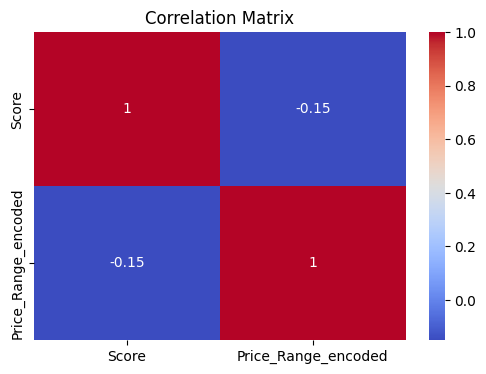

In [29]:
# Plot the correlation matrix
plt.figure(figsize=(6, 4))
sns.heatmap(round(correlation, 2), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

In [30]:
df.columns

Index(['Name', 'Score', 'Category', 'Price_Range', 'Price_Range_encoded'], dtype='object')

In [31]:
selected_features = ['Score', 'Price_Range_encoded']

In [33]:
df_selected = df[selected_features]


In [43]:
# Prepare data
X = df_selected


# sacle the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [50]:
X_scaled.shape

(770, 2)

## Kmeans

In [45]:
wcss = []
for i in range(1, 20):  # Test 1 to 20 clusters
    kmeans = KMeans(n_clusters=i,
                    init='k-means++',
                    max_iter=300,
                    n_init=10,
                    random_state=0)
    kmeans.fit(X_scaled)
    wcss.append(kmeans.inertia_)  # inertia_ is the WCSS

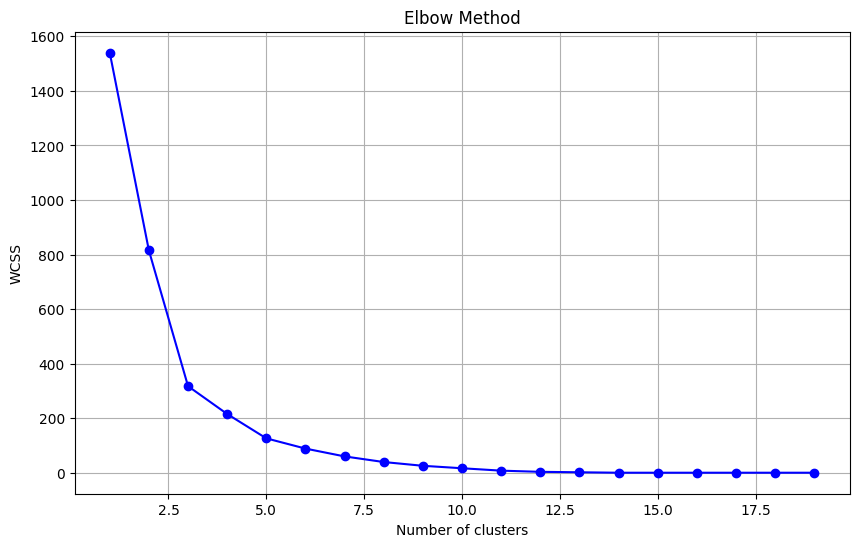

In [46]:
# 3. Plot the Elbow Curve
plt.figure(figsize=(10, 6))
plt.plot(range(1, 20), wcss,  marker='o', linestyle='-', color='b')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.grid(True)
plt.show()

In [47]:
# Appling k-Means using the optimal number of clusters, which is 3 in this case.
optimal_clusters = 3 
model = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=1)

In [48]:
# Fit the model on the training data
y_pred = model.fit_predict(X_scaled)

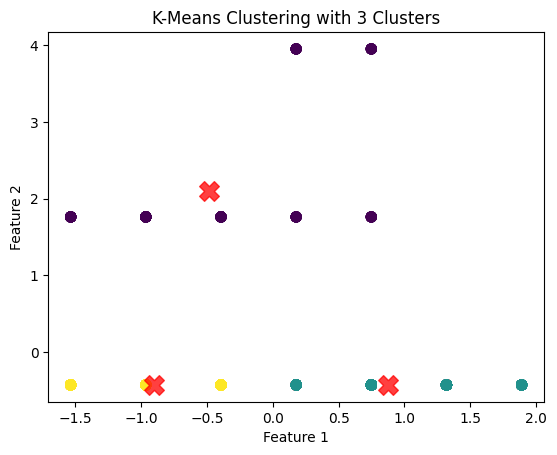

In [49]:
# Plotting the clusters with optimal number
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_pred, s=50, cmap='viridis')

centers = model.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='red', s=200, alpha=0.75, marker='X')
plt.title(f'K-Means Clustering with {optimal_clusters} Clusters')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.show()

In [55]:
X['kmeans'] = y_pred
X['kmeans'].value_counts()

kmeans
1    360
2    280
0    130
Name: count, dtype: int64

In [56]:
X

,Score,Price_Range_encoded,kmeans
0,9.3,0,1
1,9.2,1,0
2,9.2,0,2
3,9.1,0,2
4,9.1,1,0
...,...,...,...
765,9.1,0,2
766,9.1,1,0
767,9.0,0,2
768,9.0,0,2


<Axes: xlabel='Score', ylabel='Price_Range_encoded'>

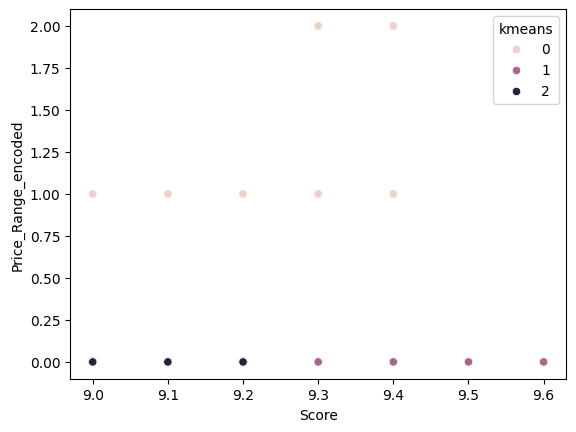

In [57]:
sns.scatterplot(data = X , x = 'Score', y = 'Price_Range_encoded', hue = 'kmeans')

## DBSCAN

In [77]:
# 2. Use NearestNeighbors to find the optimal eps
min_samples = 50

In [78]:
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
distances, indices = nn.kneighbors(X_scaled)

In [79]:
#indices
distances[:,min_samples-1]

array([0.        , 0.5705739 , 0.        , 0.        , 0.5705739 ,
       0.5705739 , 0.        , 0.        , 0.        , 0.5705739 ,
       0.        , 0.        , 0.5705739 , 0.5705739 , 0.        ,
       0.        , 0.        , 0.5705739 , 0.        , 0.        ,
       0.5705739 , 0.5705739 , 0.        , 0.        , 0.        ,
       0.5705739 , 0.        , 0.        , 0.5705739 , 0.5705739 ,
       0.        , 0.        , 0.        , 0.5705739 , 0.        ,
       0.        , 0.5705739 , 0.5705739 , 0.        , 0.        ,
       0.        , 0.5705739 , 0.        , 0.        , 0.5705739 ,
       0.5705739 , 0.        , 0.        , 0.        , 0.5705739 ,
       0.        , 0.        , 0.5705739 , 0.5705739 , 0.        ,
       0.        , 0.        , 0.5705739 , 0.        , 0.        ,
       0.5705739 , 0.5705739 , 0.        , 0.        , 0.        ,
       0.5705739 , 0.        , 0.        , 0.5705739 , 0.5705739 ,
       0.        , 0.        , 0.        , 0.5705739 , 0.     

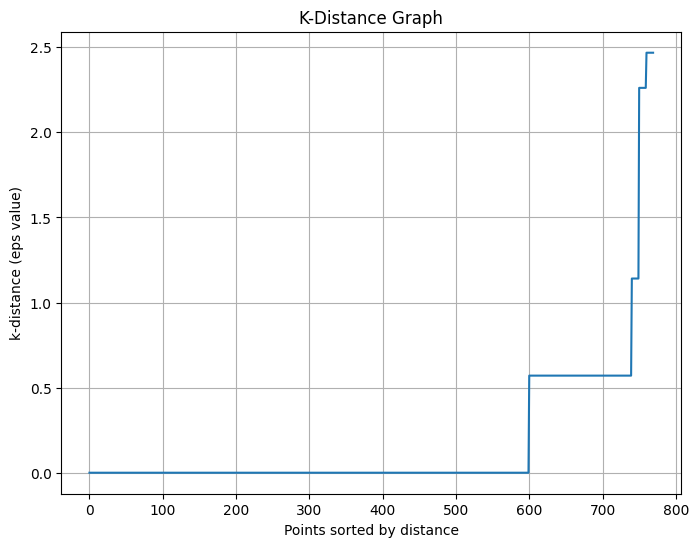

In [80]:
# The distance to the furthest neighbor (min_samples-th nearest) for each point
k_dist = distances[:, min_samples-1]

# Sort distances
k_dist_sorted = np.sort(k_dist)

# 3. Plotting the k-distance graph
plt.figure(figsize=(8, 6))
plt.plot(k_dist_sorted)
plt.title('K-Distance Graph')
plt.xlabel('Points sorted by distance')
plt.ylabel('k-distance (eps value)')
plt.grid(True)
plt.show()

# Create a Plotly figure
fig = go.Figure()

# Add a line trace
fig.add_trace(go.Scatter(
    y=k_dist_sorted,
    mode='lines',
    name='k-distance (eps value)'
))

# Update the layout
fig.update_layout(
    title='K-Distance Graph',
    xaxis_title='Points sorted by distance',
    yaxis_title='k-distance (eps value)',
    template='plotly_white',
    width=800,
    height=600
)

# Show the plot
fig.show()



In [100]:
# 4. Apply DBSCAN with chosen epslon and min_samples
# Typically, we choose eps at the "elbow" point in this plot, where the slope changes significantly, which is almost 1.6 in this problem.
chosen_eps = 0.55
dbscan = DBSCAN(eps=chosen_eps, min_samples=min_samples)

In [101]:
# Fit the model on the training data

clusters = dbscan.fit_predict(X_scaled)

In [102]:
pd.Series(clusters).value_counts()


-1    170
 5    140
 1    110
 0     90
 2     90
 4     90
 3     80
Name: count, dtype: int64

In [105]:
silhouette_avg = silhouette_score(X, clusters)
silhouette_avg

0.8306833603271382

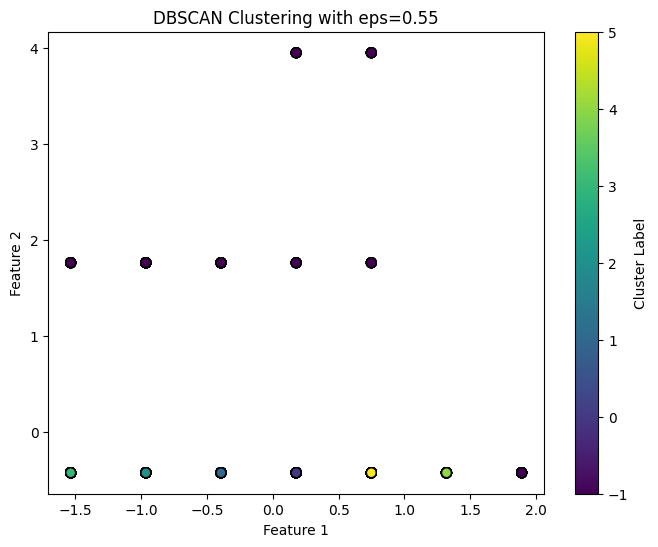

In [106]:
# 5. Plot the clustering result
plt.figure(figsize=(8, 6))
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=clusters, cmap='viridis', s=50, edgecolor='k')
plt.title(f'DBSCAN Clustering with eps={chosen_eps}')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.colorbar(label='Cluster Label')
plt.show()

In [107]:
X

,Score,Price_Range_encoded,kmeans
0,9.3,0,1
1,9.2,1,0
2,9.2,0,2
3,9.1,0,2
4,9.1,1,0
...,...,...,...
765,9.1,0,2
766,9.1,1,0
767,9.0,0,2
768,9.0,0,2


In [108]:
X['dbscan'] = clusters
X['dbscan'].value_counts()


dbscan
-1    170
 5    140
 1    110
 0     90
 2     90
 4     90
 3     80
Name: count, dtype: int64

<Axes: xlabel='Score', ylabel='Price_Range_encoded'>

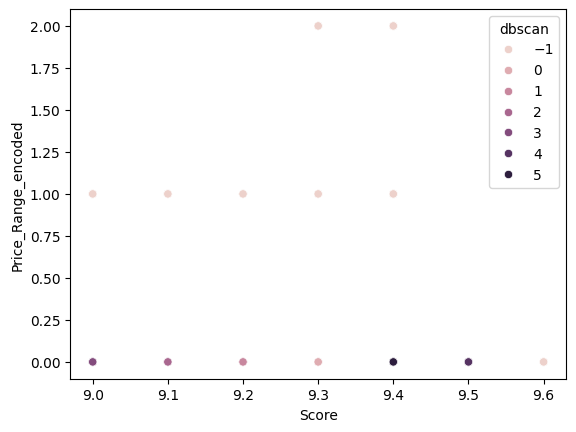

In [109]:
sns.scatterplot(data = X , x = 'Score', y = 'Price_Range_encoded', hue = 'dbscan')